In [1]:
import os
import sys
import time
import random
import pandas as pd
from pathlib import Path
import numpy as np
import torch

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

from side_info_decoding.utils import (
    set_seed, 
    load_data_from_pids, 
    sliding_window_over_trials
)
from side_info_decoding.reduced_rank import (
    Multi_Task_Reduced_Rank_Model, 
    train_multi_task, 
    model_eval
)

seed = 666
set_seed(seed)

In [2]:
%matplotlib inline
plt.rc("figure", dpi=100)
SMALL_SIZE = 10
BIGGER_SIZE = 15
plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('axes', linewidth=2)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=2)
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.minor.size'] = 10
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.minor.size'] = 10

In [3]:
pids = [
    "dab512bd-a02d-4c1f-8dbc-9155a163efc0",
    "febb430e-2d50-4f83-87a0-b5ffbb9a4943",
    # "523f8301-4f56-4faf-ab33-a9ff11331118",
    # "84bb830f-b9ff-4e6b-9296-f458fb41d160",
    # '0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a',
    # '143dd7cf-6a47-47a1-906d-927ad7fe9117',
    # '16799c7a-e395-435d-a4c4-a678007e1550',
    # '1a60a6e1-da99-4d4e-a734-39b1d4544fad',
    # '1e176f17-d00f-49bb-87ff-26d237b525f1',
    # '31f3e083-a324-4b88-b0a4-7788ec37b191'
]

In [4]:
X_dict, Y_dict = load_data_from_pids(
    pids,
    brain_region="lp",
    behavior="choice",
    data_type="all_ks",
    n_t_bins = 30
)

pulling data from ibl database ..
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
number of trials found: 265 (active: 265)
prior for this session is not found.
found 265 trials from 17.56 to 2310.24 sec.
found 131 Kilosort units in region lp


Compute spike count: 100%|██████████████████| 265/265 [00:00<00:00, 1512.10it/s]


pulling data from ibl database ..
eid: db4df448-e449-4a6f-a0e7-288711e7a75a
pid: febb430e-2d50-4f83-87a0-b5ffbb9a4943
number of trials found: 230 (active: 230)
prior for this session is not found.
found 230 trials from 40.81 to 2252.10 sec.
found 74 Kilosort units in region lp


Compute spike count: 100%|██████████████████| 230/230 [00:00<00:00, 5188.68it/s]


In [5]:
# an example of model training and eval

start_time = time.time()

example_pid = pids[0]

R = 2 # rank
d = 0 # half window size
n_epochs = 7000

# prepare data
n_units = []
train_X_lst, train_Y_lst, test_X_lst, test_Y_lst = [], [], [], []
for pid in pids:
    X, Y = X_dict[pid], Y_dict[pid]
    K, C, T = X.shape
    X = sliding_window_over_trials(X, half_window_size=d)
    Y = sliding_window_over_trials(Y, half_window_size=d)
    X, Y = torch.tensor(X), torch.tensor(Y)
    train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2, random_state=seed)
    train_X_lst.append(train_X)
    train_Y_lst.append(train_Y)
    test_X_lst.append(test_X)
    test_Y_lst.append(test_Y)
    n_units.append(C)

    
multi_task_rrm = Multi_Task_Reduced_Rank_Model(
    n_tasks=len(pids),
    n_units=n_units, 
    n_t_bins=T, 
    rank=R, 
    half_window_size=d
)

# training
multi_task_rrm, train_losses = train_multi_task(
    model=multi_task_rrm,
    train_dataset=(train_X_lst, train_Y_lst),
    test_dataset=(test_X_lst, test_Y_lst),
    loss_function=torch.nn.BCELoss(),
    learning_rate=1e-3,
    weight_decay=1e-3,
    n_epochs=n_epochs,
)

# eval
test_U, test_V, test_metrics = model_eval(
    multi_task_rrm, 
    train_dataset=(train_X_lst, train_Y_lst),
    test_dataset=(test_X_lst, test_Y_lst),
    behavior="choice"
)

end_time = time.time()
print(f"time spent: {end_time - start_time: .3f} seconds")

Epoch [700/7000], Loss: 11.140150288915041
Epoch [1400/7000], Loss: 9.848919512405175
Epoch [2100/7000], Loss: 8.496253044783368
Epoch [2800/7000], Loss: 7.661795339588318
Epoch [3500/7000], Loss: 6.407894673383343
Epoch [4200/7000], Loss: 4.821703298261905
Epoch [4900/7000], Loss: 3.1809309308400024
Epoch [5600/7000], Loss: 1.0365116627411715
Epoch [6300/7000], Loss: 0.2466025586969383
Epoch [7000/7000], Loss: 0.09209341718013468
task 0 train accuracy: 1.000 auc: 1.000
task 0 test accuracy: 0.774 auc: 0.760
task 1 train accuracy: 0.995 auc: 0.992
task 1 test accuracy: 0.761 auc: 0.835
time spent:  21.250 seconds


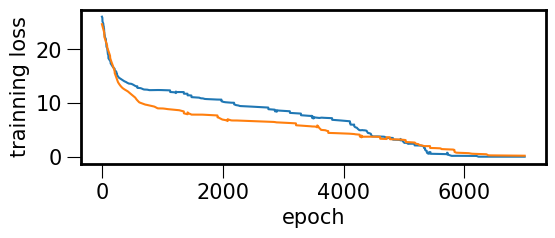

In [6]:
plt.figure(figsize=(6,2))
plt.plot(train_losses)
plt.xlabel("epoch")
plt.ylabel("trainning loss")
plt.show()

In [5]:
R = 2 # rank
d = 0 # half window size
n_epochs = 7000
n_folds = 5

skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

n_units = []
train_X_dict, test_X_dict, train_Y_dict, test_Y_dict = {}, {}, {}, {}
for pid in pids:
    X, Y = X_dict[pid], Y_dict[pid]
    K, C, T = X.shape
    n_units.append(C)
    X = sliding_window_over_trials(X, half_window_size=d)
    Y = sliding_window_over_trials(Y, half_window_size=d)
    X, Y = torch.tensor(X), torch.tensor(Y)
    train_X_dict.update({pid: [X[train] for train, _ in skf.split(X, Y)]})
    test_X_dict.update({pid: [X[test] for _, test in skf.split(X, Y)]})
    train_Y_dict.update({pid: [Y[train] for train, _ in skf.split(X, Y)]})
    test_Y_dict.update({pid: [Y[test] for _, test in skf.split(X, Y)]})

In [6]:
# example of performing 5-fold CV on all sessions

start_time = time.time()

skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

U_per_fold, V_per_fold, metrics_per_fold = [], [], []
for fold_idx in range(n_folds):
    
    print(f"start training fold {fold_idx+1} on {len(pids)} sessions ..")
    train_X_lst = [train_X_dict[pid][fold_idx] for pid in pids]
    test_X_lst = [test_X_dict[pid][fold_idx] for pid in pids]
    train_Y_lst = [train_Y_dict[pid][fold_idx] for pid in pids]
    test_Y_lst = [test_Y_dict[pid][fold_idx] for pid in pids]
    
    multi_task_rrm = Multi_Task_Reduced_Rank_Model(
        n_tasks=len(pids),
        n_units=n_units, 
        n_t_bins=T, 
        rank=R, 
        half_window_size=d
    )

    # training
    multi_task_rrm, train_losses = train_multi_task(
        model=multi_task_rrm,
        train_dataset=(train_X_lst, train_Y_lst),
        test_dataset=(test_X_lst, test_Y_lst),
        loss_function=torch.nn.BCELoss(),
        learning_rate=1e-3,
        weight_decay=1e-1,
        n_epochs=n_epochs,
    )

    # eval
    test_U, test_V, test_metrics = model_eval(
        multi_task_rrm, 
        train_dataset=(train_X_lst, train_Y_lst),
        test_dataset=(test_X_lst, test_Y_lst),
        behavior="choice"
    )
    U_per_fold.append(test_U)
    V_per_fold.append(test_V)
    metrics_per_fold.append(test_metrics)

end_time = time.time()
print(f"time spent: {end_time - start_time: .3f} seconds")

start training fold 1 on 2 sessions ..
Epoch [700/7000], Loss: 5.012372677606858
Epoch [1400/7000], Loss: 0.3068262565062939
Epoch [2100/7000], Loss: 0.12861923296920483
Epoch [2800/7000], Loss: 0.130129445066
Epoch [3500/7000], Loss: 0.12672706017748844
Epoch [4200/7000], Loss: 0.12707211243415936
Epoch [4900/7000], Loss: 0.1270802921653092
Epoch [5600/7000], Loss: 0.12548763827187548
Epoch [6300/7000], Loss: 0.12491252101781387
Epoch [7000/7000], Loss: 0.1238647171917892
task 0 train accuracy: 0.986 auc: 1.000
task 0 test accuracy: 0.868 auc: 0.962
task 1 train accuracy: 0.995 auc: 0.999
task 1 test accuracy: 0.935 auc: 0.971
start training fold 2 on 2 sessions ..
Epoch [700/7000], Loss: 11.272044990037328
Epoch [1400/7000], Loss: 3.087354088459743
Epoch [2100/7000], Loss: 0.409796894902022
Epoch [2800/7000], Loss: 0.3670595637645975
Epoch [3500/7000], Loss: 0.109732404699497
Epoch [4200/7000], Loss: 0.10882699883114821
Epoch [4900/7000], Loss: 0.11103938579446344
Epoch [5600/7000], 

In [7]:
Us, Vs, metrics_dict = {}, {}, {}
for pid_idx, pid in enumerate(pids):
    metrics_dict.update({pid: np.mean(metrics_per_fold, 0)[pid_idx]})
    Us.update({pid: [U_per_fold[fold_idx][pid_idx] for fold_idx in range(n_folds)]})
    Vs.update({pid: V_per_fold})

metrics_df = pd.DataFrame(metrics_dict).T
metrics_df.columns = ["accuracy", "auc"]
metrics_df

,accuracy,auc
dab512bd-a02d-4c1f-8dbc-9155a163efc0,0.905660,0.953791
febb430e-2d50-4f83-87a0-b5ffbb9a4943,0.913043,0.967545


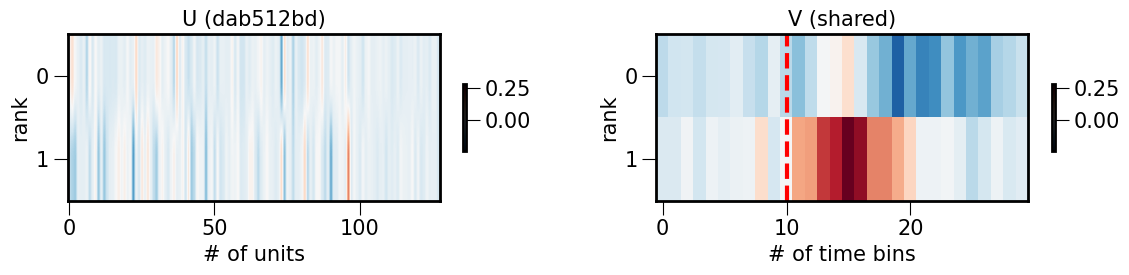

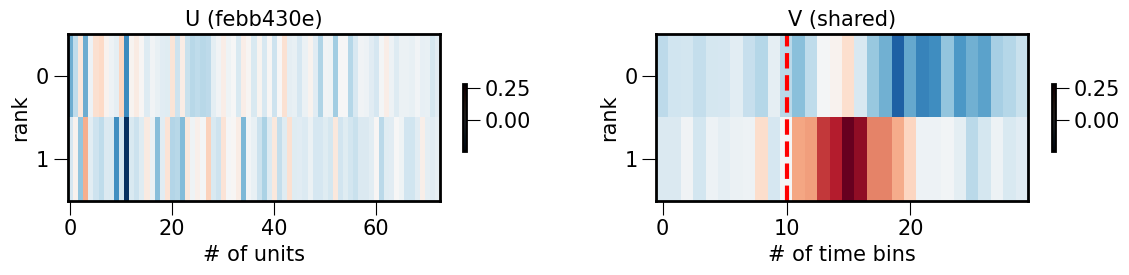

In [8]:
Us_plot, Vs_plot = [], []
for pid in pids:
    # average U and V across trials
    Us_plot.append(np.array(Us[pid]).mean(0))
    Vs_plot.append(np.array(Vs[pid]).mean(0).squeeze().T)
u_min, u_max = np.min(np.concatenate(Us_plot)), np.max(np.concatenate(Us_plot))
v_min, v_max = np.min(np.concatenate(Vs_plot)), np.max(np.concatenate(Vs_plot))
c_min, c_max = np.min([u_min, v_min]), np.max([u_max, v_max])
    
for pid_idx, pid in enumerate(pids):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 3))
    heatmap1 = ax1.imshow(Us_plot[pid_idx].T, aspect="auto", cmap="RdBu_r", vmin=c_min, vmax=c_max)
    heatmap2 = ax2.imshow(Vs_plot[pid_idx].T, aspect="auto", cmap="RdBu_r", vmin=c_min, vmax=c_max)
    ax2.axvline(x=10, c="red", linestyle="--", linewidth=3)
    cbar = fig.colorbar(heatmap1, ax=ax1, shrink=0.4)
    cbar = fig.colorbar(heatmap2, ax=ax2, shrink=0.4)
    ax1.set_ylabel("rank")
    ax1.set_xlabel("# of units")
    ax1.set_title(f"U ({pid[:8]})")
    ax2.set_ylabel("rank")
    ax2.set_xlabel("# of time bins")
    ax2.set_title(f"V (shared)")
    plt.tight_layout()

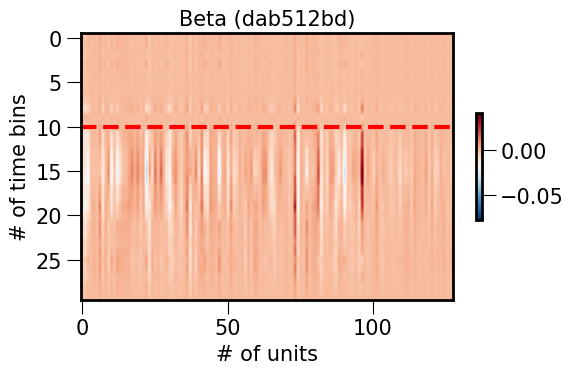

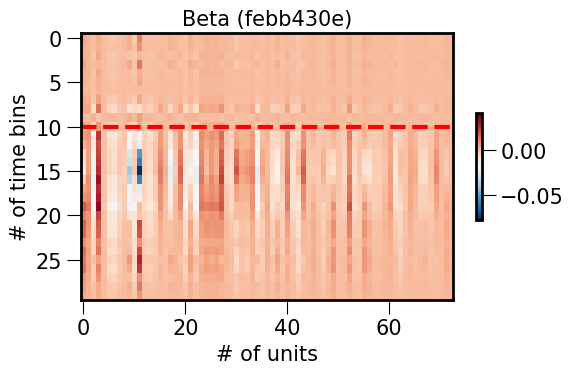

In [16]:
Betas_plot = []
for pid_idx, pid in enumerate(pids):
    # average Beta across trials
    Betas_plot.append(Us_plot[pid_idx] @ Vs_plot[pid_idx].T)
beta_min, beta_max = np.min(np.concatenate(Betas_plot)), np.max(np.concatenate(Betas_plot))
    
for pid_idx, pid in enumerate(pids):
    fig, ax = plt.subplots(1,1, figsize=(6, 4))
    heatmap = ax.imshow(Betas_plot[pid_idx].T, aspect="auto", cmap="RdBu_r", vmin=beta_min, vmax=beta_max)
    ax.axhline(y=10, c="red", linestyle="--", linewidth=3)
    cbar = fig.colorbar(heatmap, ax=ax, shrink=0.4)
    ax.set_ylabel("# of time bins")
    ax.set_xlabel("# of units")
    ax.set_title(f"Beta ({pid[:8]})")
    plt.tight_layout()

#### decode prior

In [4]:
X_dict, Y_dict = load_data_from_pids(
    pids,
    brain_region="lp",
    behavior="prior",
    data_type="all_ks",
    n_t_bins = 30,
    prior_path = "/mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org/paper_repro_ephys_data/figure9_10/priors/"
)

pulling data from ibl database ..
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
number of trials found: 265 (active: 265)
found 265 trials from 17.56 to 2310.24 sec.
found 131 Kilosort units in region lp


Compute spike count: 100%|██████████████████| 265/265 [00:00<00:00, 1493.93it/s]


pulling data from ibl database ..
eid: db4df448-e449-4a6f-a0e7-288711e7a75a
pid: febb430e-2d50-4f83-87a0-b5ffbb9a4943
number of trials found: 230 (active: 230)
found 230 trials from 40.81 to 2252.10 sec.
found 74 Kilosort units in region lp


Compute spike count: 100%|██████████████████| 230/230 [00:00<00:00, 5225.90it/s]


In [24]:
R = 2 # rank
d = 3 # half window size
n_epochs = 7000
n_folds = 5

kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)

n_units = []
test_idx_dict = {}
train_X_dict, test_X_dict, train_Y_dict, test_Y_dict = {}, {}, {}, {}
for pid in pids:
    X, Y = X_dict[pid], Y_dict[pid]
    K, C, T = X.shape
    n_units.append(C)
    X = sliding_window_over_trials(X, half_window_size=d)
    Y = sliding_window_over_trials(Y, half_window_size=d)
    X, Y = torch.tensor(X), torch.tensor(Y)
    train_X_dict.update({pid: [X[train] for train, _ in kf.split(X, Y)]})
    test_X_dict.update({pid: [X[test] for _, test in kf.split(X, Y)]})
    train_Y_dict.update({pid: [Y[train] for train, _ in kf.split(X, Y)]})
    test_Y_dict.update({pid: [Y[test] for _, test in kf.split(X, Y)]})
    test_idx_dict.update({pid: [test for _, test in kf.split(X, Y)]})

In [25]:
# example of performing 5-fold CV on all sessions

start_time = time.time()

U_per_fold, V_per_fold, metrics_per_fold = [], [], []
y_obs_per_fold, y_pred_per_fold = [], []
for fold_idx in range(n_folds):
    
    print(f"start training fold {fold_idx+1} on {len(pids)} sessions ..")
    train_X_lst = [train_X_dict[pid][fold_idx] for pid in pids]
    test_X_lst = [test_X_dict[pid][fold_idx] for pid in pids]
    train_Y_lst = [train_Y_dict[pid][fold_idx] for pid in pids]
    test_Y_lst = [test_Y_dict[pid][fold_idx] for pid in pids]
    
    multi_task_rrm = Multi_Task_Reduced_Rank_Model(
        n_tasks=len(pids),
        n_units=n_units, 
        n_t_bins=T, 
        rank=R, 
        half_window_size=d
    )

    # training
    multi_task_rrm, train_losses = train_multi_task(
        model=multi_task_rrm,
        train_dataset=(train_X_lst, train_Y_lst),
        test_dataset=(test_X_lst, test_Y_lst),
        loss_function=torch.nn.MSELoss(),
        learning_rate=1e-3,
        weight_decay=1e-1,
        n_epochs=n_epochs,
    )

    # eval
    test_U, test_V, test_metrics, test_pred_lst = model_eval(
        multi_task_rrm, 
        train_dataset=(train_X_lst, train_Y_lst),
        test_dataset=(test_X_lst, test_Y_lst),
        behavior="prior"
    )
    U_per_fold.append(test_U)
    V_per_fold.append(test_V)
    metrics_per_fold.append(test_metrics)
    y_obs_per_fold.append(test_Y_lst)
    y_pred_per_fold.append(test_pred_lst)

end_time = time.time()
print(f"time spent: {end_time - start_time: .3f} seconds")

start training fold 1 on 2 sessions ..
Epoch [700/7000], Loss: 0.26905370304735443
Epoch [1400/7000], Loss: 0.2018024943348473
Epoch [2100/7000], Loss: 0.13929854009158738
Epoch [2800/7000], Loss: 0.05457176535733879
Epoch [3500/7000], Loss: 0.025041719469578932
Epoch [4200/7000], Loss: 0.021302316960843285
Epoch [4900/7000], Loss: 0.021742555741778986
Epoch [5600/7000], Loss: 0.022128837803226543
Epoch [6300/7000], Loss: 0.02219072469863924
Epoch [7000/7000], Loss: 0.022225175390480467
task 0 train r2: 0.664 corr: 0.875
task 0 test r2: 0.555 corr: 0.828
task 1 train r2: 0.705 corr: 0.913
task 1 test r2: 0.457 corr: 0.719
start training fold 2 on 2 sessions ..
Epoch [700/7000], Loss: 0.2613029590792389
Epoch [1400/7000], Loss: 0.20773730768555995
Epoch [2100/7000], Loss: 0.1361802773560585
Epoch [2800/7000], Loss: 0.05147747788319425
Epoch [3500/7000], Loss: 0.02382141158709283
Epoch [4200/7000], Loss: 0.023019784981177842
Epoch [4900/7000], Loss: 0.023551712959620608
Epoch [5600/7000]

In [26]:
Us, Vs, metrics_dict, y_obs, y_pred = {}, {}, {}, {}, {}
for pid_idx, pid in enumerate(pids):
    metrics_dict.update({pid: np.mean(metrics_per_fold, 0)[pid_idx]})
    Us.update({pid: [U_per_fold[fold_idx][pid_idx] for fold_idx in range(n_folds)]})
    Vs.update({pid: V_per_fold})
    test_idx_per_pid = np.concatenate(test_idx_dict[pid])
    y_obs_per_pid = np.concatenate([y_obs_per_fold[fold_idx][pid_idx] for fold_idx in range(n_folds)])
    y_pred_per_pid = np.concatenate([y_pred_per_fold[fold_idx][pid_idx] for fold_idx in range(n_folds)])
    y_obs.update({pid: y_obs_per_pid[np.argsort(test_idx_per_pid)]})
    y_pred.update({pid: y_pred_per_pid[np.argsort(test_idx_per_pid)]})

metrics_df = pd.DataFrame(metrics_dict).T
metrics_df.columns = ["r2", "corr"]
metrics_df

,r2,corr
dab512bd-a02d-4c1f-8dbc-9155a163efc0,0.571396,0.828062
febb430e-2d50-4f83-87a0-b5ffbb9a4943,0.562966,0.819854


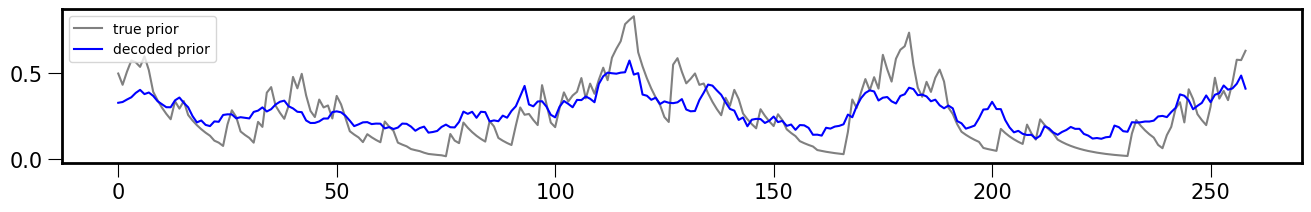

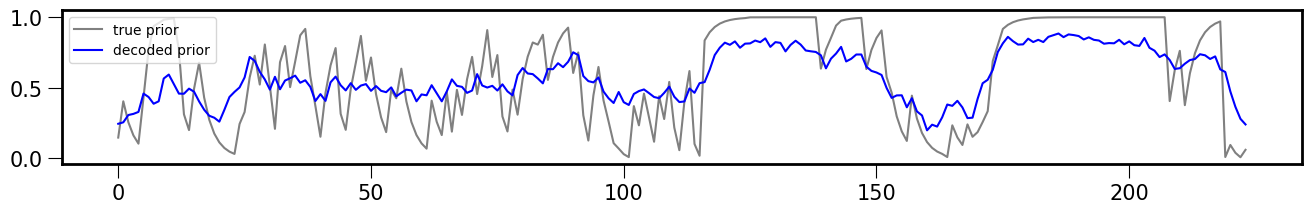

In [30]:
for pid in pids:
    plt.figure(figsize=(16,2))
    plt.plot(y_obs[pid], color="gray", label="true prior")
    plt.plot(y_pred[pid], color="blue", label="decoded prior")
    plt.legend()
    plt.show()